
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain Anual Weather Types (AWT) following the methodology explained in Anderson et al. (2019)

inputs required: 
  * Averaged monthly Sea Surface Temperature (SST) anomalies. Extracted from the Extended Reconstructed Sea Surface Temperature v4 (ERSSTv4; Huang et al., (2015)). Rectangular region from 120°E to 280°E and 5°N to 5°S 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import pickle
from datetime import datetime

# pip
import xarray as xr
import numpy as np
np.set_printoptions(precision=3)

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit 
#from teslakit.database import Database
from teslakit.pca import PCA_LatitudeAverage
from teslakit.kma import KMA_simple, ClusterProbabilities, ChangeProbabilities
from teslakit.statistical import CopulaSimulation
from teslakit.alr import ALR_WRP

from teslakit.plotting.awt import Plot_AWTs_EOFs, Plot_AWTs, Plot_AWTs_Dates, Plot_AWTs_Validation
from teslakit.plotting.pcs import Plot_PCs_Compare_3D, Plot_PCs_WT
from teslakit.plotting.wts import Plot_Compare_Transitions

from teslakit.io.aux_nc import StoreBugXdset
from teslakit.util.time_operations import xds_reindex_daily, xds_reindex_monthly



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

site ='ROI'
p_data = r'/Users/albacid/Projects/TeslaKit_projects/sites/' + site + '/'

p_outputs = p_data + 'ClimateChange/'
import os
if not os.path.exists(p_outputs):
    os.makedirs(p_outputs)    


In [3]:
# --------------------------------------
# load data and set parameters
SST_AWTs = xr.open_dataset(p_data + 'SST/SST_KMA.nc')
bmus_hist = SST_AWTs.bmus.values[:] + 1 # for plotting comparison

# Load SST PCs123 random generated with Copulas
pickle_in = open(p_data + 'SST/SST_dPCs_fit.pickle',"rb")
PCs_fit = pickle.load(pickle_in)

pickle_in = open(p_data + 'SST/SST_dPCs_rnd.pickle',"rb")
PCs_rnd = pickle.load(pickle_in)

# SST Predictor PCA parameters
pca_year_ini = 1880
pca_year_end = 2016
pca_month_ini = 6
pca_month_end = 5
num_clusters = 6

# New AWT probabilities (expected probabilities under rcp8.5)
#WT_probs_new = [13.34, 12.07, 19.51, 12.49, 25.19, 17.40] # must sum 100%
WT_probs_new = [15, 20, 5, 30, 10, 20]
WT_probs_new = [x/100 for x in WT_probs_new]

# Simulation
num_sims = 10
y1_sim = 2000
y2_sim = 3000


## Present & Future AWT probabilities

In [4]:
# Get probability of each AWT (just for info)
set_values = np.arange(num_clusters) + 1
WT_probs = ClusterProbabilities(bmus_hist, set_values)

print('current AWT probabilities')
print(WT_probs)
print(np.sum(WT_probs)) 

print('future AWT probabilities')
print(WT_probs_new)
print(np.sum(WT_probs_new))
print()


# Get current transition probability matrix
set_values = np.arange(num_clusters) + 1
WT_trans_matrix = ChangeProbabilities(bmus_hist, set_values)[1] # matriz probs cambio (markov 1)
#print(WT_trans_matrix)
#print()
#print(np.sum(WT_trans_matrix, axis=1))  # sum cols
#print()


# Obtain stable AWTs probabilities from current transition probability matrix
A = np.append(np.transpose(WT_trans_matrix)-np.identity(num_clusters), np.ones((1,num_clusters)), axis=0)
b = np.append(np.zeros((num_clusters,1)),[[1]])
WT_probs_stable = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

print('stable AWT probabilities from current transition probability matrix (markov=1)')
print(WT_probs_stable)
print(np.sum(WT_probs_stable))


current AWT probabilities
[0.131 0.131 0.19  0.139 0.204 0.204]
1.0
future AWT probabilities
[0.15, 0.2, 0.05, 0.3, 0.1, 0.2]
1.0

stable AWT probabilities from current transition probability matrix (markov=1)
[0.133 0.132 0.184 0.141 0.204 0.206]
1.0


## Modify transition probability matrix according to future AWT probs


In [5]:

# Obtain alfa and beta (parameters that modify each WT transition prob). Solves a linear matrix equation

alfa_p = np.identity(num_clusters)
beta_p = WT_trans_matrix

alfa_q = np.zeros(np.shape(WT_trans_matrix))*np.nan
for i in range(num_clusters):    
    for j in range(num_clusters):
    
        alfa_q[i,j] = beta_p[j][i]*WT_probs_new[j]

        
beta_q = np.zeros(np.shape(WT_trans_matrix))
for i in range(num_clusters):
    
    beta_q[i,i] = np.sum(alfa_q, axis=1)[i]

    
A = np.concatenate((alfa_p, beta_p), axis=1)
B = np.concatenate((alfa_q, beta_q), axis=1)
a = np.concatenate((A,B), axis=0)


b = np.zeros((1,num_clusters*2))
b = b[0] 
for i in range(num_clusters):

    b[num_clusters+i] =  WT_probs_new[i]- beta_q[i][i]


# solve 
alfa_beta = np.linalg.solve(a, b)
alfa = alfa_beta[:num_clusters]
beta = alfa_beta[num_clusters:]

print(alfa)
print()
print(beta)


[-1.064 -1.46  -1.301 -1.55  -1.366 -1.269]

[1.541 1.951 0.6   2.293 0.876 1.25 ]


In [6]:
# modify transition probability matrix with obtained alfa & beta

WT_trans_matrix_new = np.zeros(np.shape(WT_trans_matrix))*np.nan

for i in range(num_clusters):
    for j in range(num_clusters):
            
        WT_trans_matrix_new[i][j] = WT_trans_matrix[i][j] * (1 + alfa[i] + beta[j])

print('transition probability matrix from historical bmus')
print(WT_trans_matrix)
print()
print('transition probability matrix modified acording to expected probs rcp8.5')
print(WT_trans_matrix_new)
print()


#---------------------
# TODO: esto se borra

# Check that the AWTs probabilites obtained from the modified transition prob matrix, are as expected
A = np.append(np.transpose(WT_trans_matrix_new)-np.identity(num_clusters), np.ones((1,num_clusters)), axis=0)
b = np.append(np.zeros((num_clusters,1)),[[1]])
WT_probs_new_stable = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

print('-------')
print(WT_probs_new)
print(WT_probs_new_stable)
print()

transition probability matrix from historical bmus
[[0.    0.056 0.333 0.111 0.333 0.167]
 [0.056 0.222 0.056 0.111 0.111 0.444]
 [0.308 0.231 0.154 0.    0.269 0.038]
 [0.278 0.167 0.167 0.222 0.056 0.111]
 [0.    0.107 0.214 0.25  0.214 0.214]
 [0.143 0.036 0.179 0.143 0.214 0.286]]

transition probability matrix modified acording to expected probs rcp8.5
[[0.    0.105 0.179 0.248 0.271 0.198]
 [0.06  0.331 0.008 0.204 0.046 0.351]
 [0.382 0.381 0.046 0.    0.155 0.037]
 [0.275 0.233 0.008 0.387 0.018 0.078]
 [0.    0.17  0.05  0.482 0.109 0.189]
 [0.182 0.06  0.059 0.289 0.13  0.28 ]]

-------
[0.15, 0.2, 0.05, 0.3, 0.1, 0.2]
[0.15 0.2  0.05 0.3  0.1  0.2 ]



## Generate future bmus (markov = 1)


In [7]:
time_sim = [datetime(y, pca_month_ini,1) for y in range(y1_sim-1, y2_sim+1)]


# bmus generation
bmus_sim = np.zeros((len(time_sim), num_sims), dtype=int) * np.nan

c = 0 # contador
for s in range(num_sims):

    ind_row = bmus_hist[:1] -1  # first bmus state. from 0 to 5

    while c < len(time_sim):

        trans_prob_wt = np.cumsum(WT_trans_matrix_new[ind_row, :])
        nrnd = np.random.rand()
        ind_col = np.where(trans_prob_wt > nrnd)[0][0]

        bmus_sim[c, s] = ind_col + 1

        ind_row = ind_col
        c += 1

    c = 0

    
    
# obtain AWTs probabilities of synthetic bmus for each sim
WT_probs_sim = np.zeros((num_sims, num_clusters)) * np.nan

for s in range(num_sims):
    WT_probs_sim[s,:] = ClusterProbabilities(bmus_sim[:,s], set_values)


# Obtain mean values of AWT probs from all simulations
WT_probs_sim_mean = np.mean(WT_probs_sim, axis=0)
print('WT probs (mean) for synthetic simulations')
print(WT_probs_sim_mean)
print()
print('future AWT probabilities')
print(WT_probs_new)


WT probs (mean) for synthetic simulations
[0.144 0.208 0.051 0.3   0.099 0.198]

future AWT probabilities
[0.15, 0.2, 0.05, 0.3, 0.1, 0.2]


In [8]:
# Save
SST_AWTs_sim = xr.Dataset(
    {
        'evbmus_sims' : (('time','n_sim'), bmus_sim.astype(int)),
    },
    coords = {
        'time' : time_sim,
        'n_sim' : range(num_sims),
    },
)


StoreBugXdset(SST_AWTs_sim, p_outputs + 'CC_SST_AWT_sim.nc')

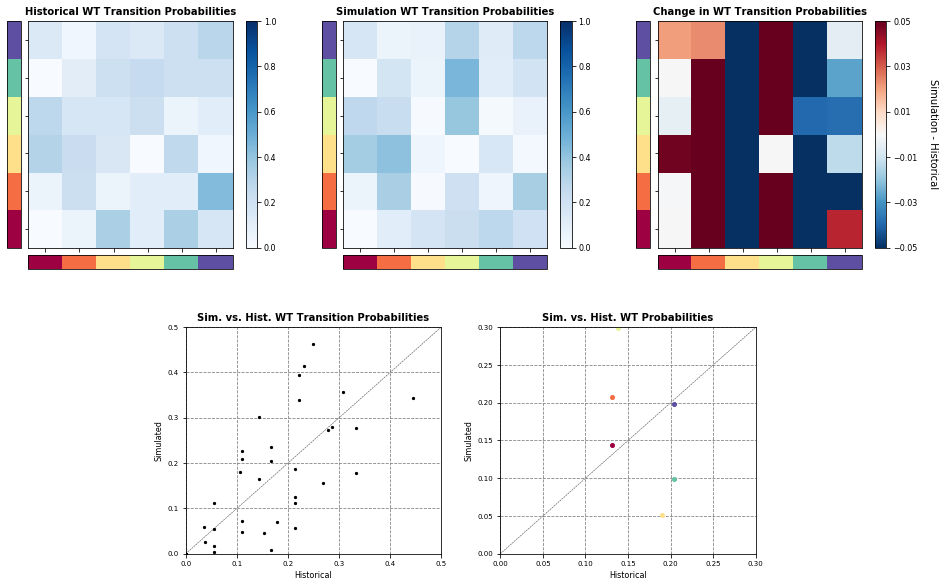

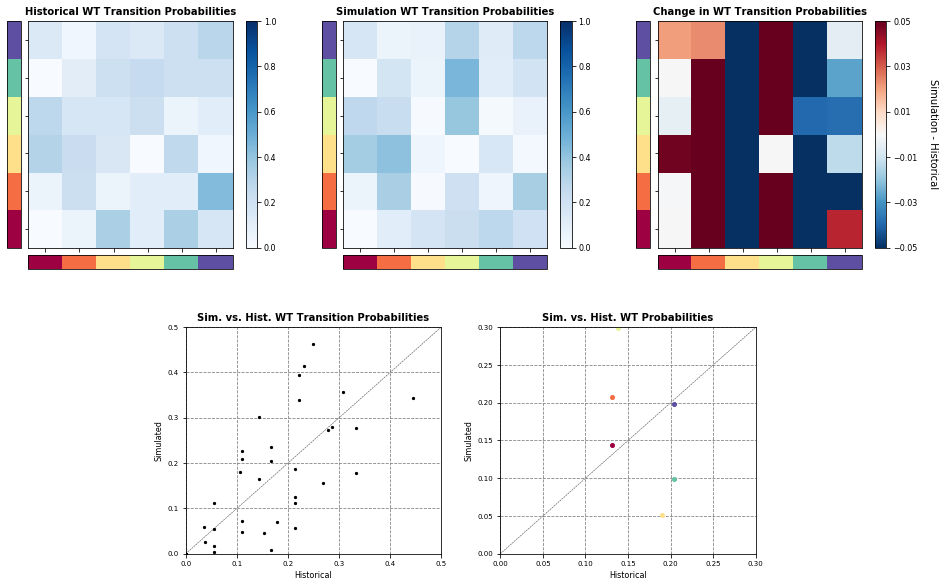

In [9]:

Plot_Compare_Transitions(num_clusters, bmus_hist, SST_AWTs_sim.evbmus_sims,
                                 sttl=None, show=True)
 

In [11]:
# --------------------------------------
# PCs generation

vari = SST_AWTs.variance.values[:]

# solve each ALR simulation
l_PCs_sim = []
for s in SST_AWTs_sim.n_sim:

    evbmus_sim = SST_AWTs_sim.sel(n_sim=s).evbmus_sims.values[:]

    # generate random PCs
    pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
    for c, m in enumerate(evbmus_sim):
        options = PCs_rnd['{0}'.format(int(m))]
        r = np.random.randint(options.shape[0])
        pcs123_sim[c,:] = options[r,:]
        
    # denormalize simulated PCs
    PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(vari[0]))
    PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(vari[1]))
    PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(vari[2]))

    # append simulated PCs
    l_PCs_sim.append(
        xr.Dataset(
            {
                'PC1'  : (('time',), PC1_sim),
                'PC2'  : (('time',), PC2_sim),
                'PC3'  : (('time',), PC3_sim),
                'evbmus_sim' : (('time',), evbmus_sim),
            },
            {'time' : time_sim}
        )
    )

# concatenate simulations
SST_PCs_sim = xr.concat(l_PCs_sim, 'n_sim')
print(SST_PCs_sim)

# store simulated PCs
StoreBugXdset(SST_PCs_sim, p_outputs + 'CC_SST_PCs_sim.nc')

# resample to daily and store
xds_d = xds_reindex_daily(SST_PCs_sim)
StoreBugXdset(xds_d, p_outputs + 'CC_SST_PCs_sim_d.nc')

# resample to monthly and store
xds_m = xds_reindex_monthly(SST_PCs_sim)
StoreBugXdset(xds_m, p_outputs + 'CC_SST_PCs_sim_m.nc')



<xarray.Dataset>
Dimensions:     (n_sim: 10, time: 1002)
Coordinates:
  * time        (time) object 1999-06-01 2000-06-01 ... 2999-06-01 3000-06-01
Dimensions without coordinates: n_sim
Data variables:
    PC1         (n_sim, time) float64 -5.946 13.08 -36.68 ... 14.21 30.99 35.21
    PC2         (n_sim, time) float64 -7.547 -4.772 8.87 ... 1.983 10.82 6.779
    PC3         (n_sim, time) float64 11.22 27.64 11.24 ... 14.73 9.542 -21.24
    evbmus_sim  (n_sim, time) int64 5 2 6 1 6 1 2 6 4 4 ... 4 2 4 2 6 5 4 2 2 1
